<center><h1>In the name of Allah</h1></center>

Name: Reza Vahidimajd

Student Number: 99102491

In this notebook, you will explore adversarial attacks and training methods in deep learning. First, you will train a simple model, ResNet18, on the CIFAR-10 dataset. Next, you will learn about two different adversarial attacks: FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent). To enhance your understanding, you will implement the PGD attack from scratch, while the FGSM attack will be implemented using a library. After this, you will use the FGSM attack to generate adversarial examples and then perform adversarial training on the model using the CIFAR-10 dataset. Finally, you will compare the performance and robustness of the adversarially trained model with the original model.

Good luck!

## outline
- Train Resnet on CIFAR10
- FGSM Attack using torchattacks
- PGD Attack from scratch
- Visualization
- Adversarial Training


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Train Resnet on CIFAR10 (15 pts)



In [ ]:
# Prepare Cifar10 data
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(),])

##############################################################################
# Prepare training and test datasets and dataloaders                         #
##############################################################################

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

################################ End #########################################

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# model architecture
class resnet(nn.Module):
  def __init__(self, num_cls):
    super().__init__()
    self.conv = nn.Sequential(*list(resnet18(weights=None).children())[:-2])
    self.fc = nn.Linear(512, num_cls)

  def forward(self, x):
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    return logits

##############################################################################
# Initialize model and move to device                                        #
##############################################################################
# model = resnet(num_cls=10).to(device)

################################ End #########################################

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

In [ ]:
##############################################################################
# Implement train loop and log training loss after each epoch                #
##############################################################################


def train(model, trainloader, criterion, optimizer, device, epochs=100):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}')
        running_loss = 0.0


train(model, trainloader, criterion, optimizer, device, epochs)
################################ End #########################################

Epoch [1/100], Loss: 1.5346
Epoch [2/100], Loss: 1.1157
Epoch [3/100], Loss: 0.9164
Epoch [4/100], Loss: 0.7710
Epoch [5/100], Loss: 0.6433
Epoch [6/100], Loss: 0.5355
Epoch [7/100], Loss: 0.4542
Epoch [8/100], Loss: 0.3622
Epoch [9/100], Loss: 0.2882
Epoch [10/100], Loss: 0.2406
Epoch [11/100], Loss: 0.1960
Epoch [12/100], Loss: 0.1680
Epoch [13/100], Loss: 0.1389
Epoch [14/100], Loss: 0.1224
Epoch [15/100], Loss: 0.0928
Epoch [16/100], Loss: 0.0876
Epoch [17/100], Loss: 0.0711
Epoch [18/100], Loss: 0.0645
Epoch [19/100], Loss: 0.0571
Epoch [20/100], Loss: 0.0565
Epoch [21/100], Loss: 0.0434
Epoch [22/100], Loss: 0.0448
Epoch [23/100], Loss: 0.0417
Epoch [24/100], Loss: 0.0352
Epoch [25/100], Loss: 0.0363
Epoch [26/100], Loss: 0.0228
Epoch [27/100], Loss: 0.0241
Epoch [28/100], Loss: 0.0293
Epoch [29/100], Loss: 0.0280
Epoch [30/100], Loss: 0.0250
Epoch [31/100], Loss: 0.0202
Epoch [32/100], Loss: 0.0163
Epoch [33/100], Loss: 0.0110
Epoch [34/100], Loss: 0.0183
Epoch [35/100], Loss: 0

In [ ]:
# torch.save(net.state_dict(), 'resnet_cifar10.pth')

In [ ]:
##############################################################################
# Evaluate the trained model on test set and print test accuracy             #
##############################################################################


def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')

test(model, testloader, device)
################################ End #########################################

Accuracy of the model on the test images: 74.15%


In [ ]:
# Save model
model.eval()
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(model.state_dict(), model_PATH)

In [ ]:
model = resnet(num_cls=10)
model.load_state_dict(torch.load("resnet18_cifar10_model_pretrained.pth"))
model = model.to(device)

## FGSM Attack using torchattacks (10 pts)

In this section you should run FGSM attack using torchattacks library (https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html).

Run the attack for $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on untargeted FGSM attack on the test data.

In [ ]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 7.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl

In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 1/255 and report its accuracy     #
##############################################################################
from torchattacks.attacks.fgsm import FGSM

epsilon = 1/255
attack = FGSM(model, eps=epsilon)

def fgsm_attack(model, testloader, attack, device):
    model.eval()
    correct = 0
    total = 0
    for data in testloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      adv_images = attack(images, labels)
      outputs = model(adv_images)
      predicted = torch.argmax(outputs, dim=1)
      total += labels.shape[0]
      correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model under FGSM attack with epsilon={epsilon}: {100 * correct / total}%')


fgsm_attack(model, testloader, attack, device)


################################ End #########################################

Accuracy of the model under FGSM attack with epsilon=0.00392156862745098: 53.17%


In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 4/255 and report its accuracy     #
##############################################################################


epsilon = 4/255
attack = FGSM(model, eps=epsilon)
fgsm_attack(model, testloader, attack, device)



################################ End #########################################

Accuracy of the model under FGSM attack with epsilon=0.01568627450980392: 23.18%


In [ ]:
##############################################################################
# run untargeted FGSM attack for epsilon = 8/255 and report its accuracy     #
##############################################################################


epsilon = 8/255
attack = FGSM(model, eps=epsilon)
fgsm_attack(model, testloader, attack, device)



################################ End #########################################

Accuracy of the model under FGSM attack with epsilon=0.03137254901960784: 10.87%


## PGD Attack from scratch (30 pts)

In this section you should implement PGD attack from scratch.

---



In [ ]:
class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def __call__(self, image, label):

        image = image.to(device)
        label = label.to(device)

        out = self.model(image)
        _, pred = torch.max(out, 1)

        perturbed_image = image.clone()
        perturbed_image.to(device).detach()
        perturbed_image.requires_grad = True

        if pred.item() == label.item():
            ##############################################################################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################

            for _ in range(self.steps):
              self.model.zero_grad()
              output = self.model(perturbed_image)
              loss = self.criterion(output, label)

              loss.backward()
              with torch.no_grad():
                sign = perturbed_image.grad.data.sign()
                perturbed_image.data = perturbed_image.data + self.alpha * sign
                # perturbed_image.data = torch.clamp(perturbed_image.data, image + self.epsilon, image - self.epsilon)
                perturbed_image.data = torch.max(torch.min(perturbed_image.data, image + self.epsilon), image - self.epsilon)
                perturbed_image.data = torch.clamp(perturbed_image.data, 0, 1)
            ################################ End #########################################

        return perturbed_image

In [ ]:
# Implement PGD attack
class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def __call__(self, image, label):
        image = image.to(device)
        label = label.to(device)

        out = self.model(image)
        _, pred = torch.max(out, 1)

        perturbed_image = image.clone()
        perturbed_image.to(device)

        if pred.item() == label.item():
            ########################## Problem 1 (8 points) ##############################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################
            for _ in range(self.steps):
              perturbed_image.requires_grad = True
              logits  = self.model(perturbed_image)
              loss = self.criterion(logits, label)

              self.model.zero_grad()
              loss.backward()

              with torch.no_grad():
                gradient_sign = perturbed_image.grad.data.sign()
                perturbed_image.data = perturbed_image.data + self.alpha * gradient_sign
                perturbed_image.data = torch.clamp(perturbed_image, image - self.epsilon, image + self.epsilon)
                perturbed_image.data = torch.clamp(perturbed_image.data, 0, 1)

            ################################ End #########################################
        return perturbed_image

In [ ]:
##############################################################################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################

def test_under_pgd_attack(model, testloader, attack, device):
    model.eval()
    correct = 0
    total = 0
    for data in testloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      for i in range(images.size(0)):
            image = images[i].unsqueeze(0)
            label = labels[i].unsqueeze(0)
            adv_image = attack(image, label)
            outputs = model(adv_image)
            predicted = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    return 100 * correct / total

k_list = [2, 4, 8]
epsilon = 8 / 255
alpha = 2 / 255

for k in k_list:
    pgd_attack = LinfPGDAttack(model, epsilon=epsilon, k=k, alpha=alpha)
    accuracy = test_under_pgd_attack(model, testloader, pgd_attack, device)
    print(f'Accuracy of the network under PGD attack with k={k}: {accuracy:.2f}%')

################################ End #########################################

Accuracy of the network under PGD attack with k=2: 16.53%
Accuracy of the network under PGD attack with k=4: 2.89%
Accuracy of the network under PGD attack with k=8: 0.80%


## Visualization (10 pts)

Implement a function to plot the original image, the perturbed imaged and their predicted labels by the model:

In [ ]:
##############################################################################
# Implement the function described                                           #
##############################################################################

def imshow(img, title):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def plot_images(original_image, perturbed_image, original_label, perturbed_label):
    original_image = original_image.cpu().squeeze(0)
    perturbed_image = perturbed_image.cpu().squeeze(0)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    imshow(original_image, f'Original Image\nLabel: {original_label}')

    plt.subplot(1, 2, 2)
    imshow(perturbed_image, f'Perturbed Image\nLabel: {perturbed_label}')

    plt.show()



################################ End #########################################

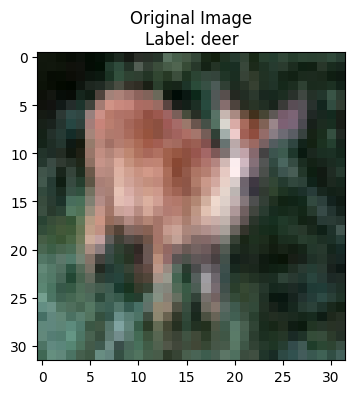

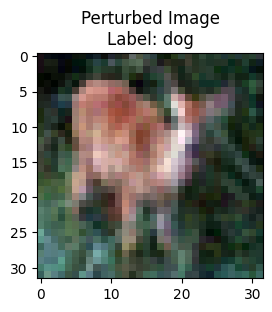

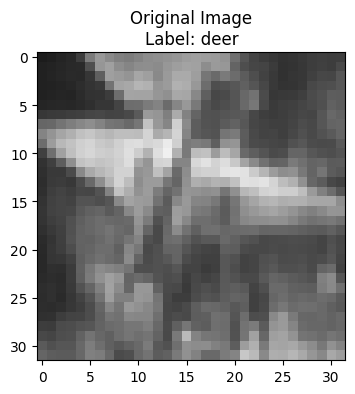

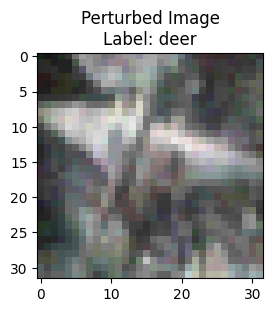

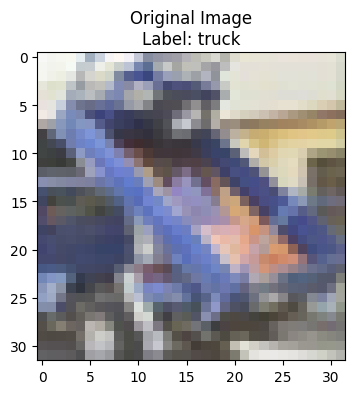

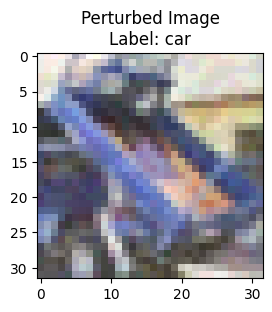

In [ ]:
##############################################################################
# Choose 3 random images from testset and run FGSM attack and visualize      #
##############################################################################
from torchattacks.attacks.fgsm import FGSM
import random
import matplotlib.pyplot as plt

epsilon = 8/255
attack = FGSM(model, eps=epsilon)
model.eval()

def visualize_random_images(testset, model, attack, num_images=3):
    indices = random.sample(range(len(testset)), num_images)
    for idx in indices:
        image, label = testset[idx]
        image = image.unsqueeze(0).to(device)
        label = torch.tensor([label]).to(device)

        adv_image = attack(image, label)
        original_output = model(image)
        perturbed_output = model(adv_image)
        original_pred = torch.argmax(original_output, dim=1).item()
        perturbed_pred = torch.argmax(perturbed_output, dim=1).item()

        plot_images(image, adv_image, classes[original_pred], classes[perturbed_pred])


visualize_random_images(testset, model, attack, num_images=3)


################################ End #########################################

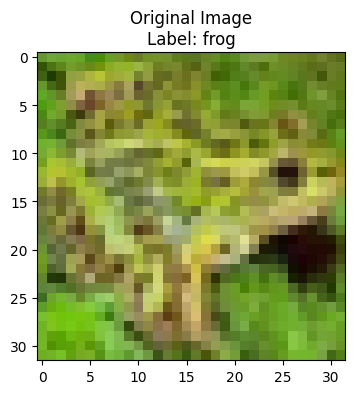

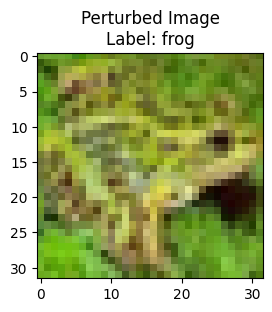

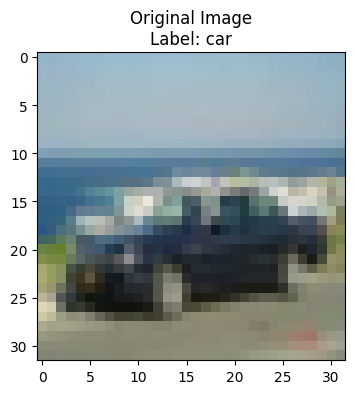

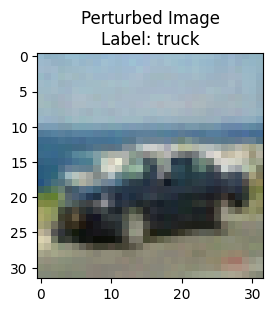

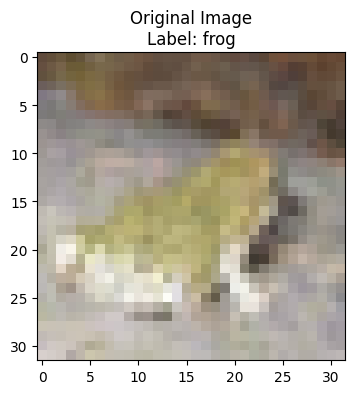

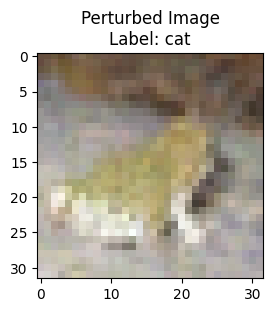

In [ ]:
##############################################################################
# Choose 3 random images from testset and run PGD attack and visualize      #
##############################################################################

pgd_attack = LinfPGDAttack(model, epsilon=8/255, k=2, alpha=2/255)
visualize_random_images(testset, model, pgd_attack, num_images=3)

################################ End #########################################

## Adversarial Training (35 pts)

In this section you are going to adversarially train your model and see the results.

In [41]:
##############################################################################
# Load a new resnet model for adversarial training                           #
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

adv_model = resnet(num_cls=10) # Your code goes here
adv_model.to(device)

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(adv_model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 100

epsilon = 8/255
fgsm_attack = FGSM(adv_model, eps=epsilon)

def train_adv_model(adv_model, trainloader, optimizer, criterion, device, epochs):
    adv_model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            adv_inputs = fgsm_attack(inputs, labels)

            optimizer.zero_grad()

            outputs = adv_model(adv_inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}')
        running_loss = 0.0

train_adv_model(adv_model, trainloader, optimizer, criterion, device, epochs)
################################ End #########################################

Epoch [1/100], Loss: 2.1294
Epoch [2/100], Loss: 1.9974
Epoch [3/100], Loss: 1.9389
Epoch [4/100], Loss: 1.8931
Epoch [5/100], Loss: 1.8507
Epoch [6/100], Loss: 1.8138
Epoch [7/100], Loss: 1.7843
Epoch [8/100], Loss: 1.7478
Epoch [9/100], Loss: 1.7159
Epoch [10/100], Loss: 1.6830
Epoch [11/100], Loss: 1.6524
Epoch [12/100], Loss: 1.6188
Epoch [13/100], Loss: 1.5807
Epoch [14/100], Loss: 1.5450
Epoch [15/100], Loss: 1.5094
Epoch [16/100], Loss: 1.4740
Epoch [17/100], Loss: 1.4329
Epoch [18/100], Loss: 1.3901
Epoch [19/100], Loss: 1.3503
Epoch [20/100], Loss: 1.3123
Epoch [21/100], Loss: 1.2734
Epoch [22/100], Loss: 1.2316
Epoch [23/100], Loss: 1.1971
Epoch [24/100], Loss: 1.1574
Epoch [25/100], Loss: 1.1199
Epoch [26/100], Loss: 1.0809
Epoch [27/100], Loss: 1.0457
Epoch [28/100], Loss: 1.0128
Epoch [29/100], Loss: 0.9873
Epoch [30/100], Loss: 0.9499
Epoch [31/100], Loss: 0.9264
Epoch [32/100], Loss: 0.8890
Epoch [33/100], Loss: 0.8601
Epoch [34/100], Loss: 0.8341
Epoch [35/100], Loss: 0

In [42]:
# Save adversarially trained model
adv_model.eval()
model_name = "resnet18_cifar10_adversarially_model_pretrained.pth"
model_PATH = f"{model_name}"
torch.save(adv_model.state_dict(), model_PATH)

In [43]:
##############################################################################
# Evaluate the new model on the test dataset                                 #
##############################################################################

def test(adv_model, testloader, device):
    adv_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = adv_model(images)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the adv_model on the test images: {100 * correct / total}%')

test(adv_model, testloader, device)

################################ End #########################################

Accuracy of the adv_model on the test images: 61.2%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [44]:
##############################################################################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################
from torchattacks.attacks.fgsm import FGSM

epsilon = 8/255
attack = FGSM(adv_model, eps=epsilon)

def fgsm_attack(adv_model, testloader, attack, device):
    adv_model.eval()
    correct = 0
    total = 0
    for data in testloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      adv_images = attack(images, labels)
      outputs = adv_model(adv_images)
      predicted = torch.argmax(outputs, dim=1)
      total += labels.shape[0]
      correct += (predicted == labels).sum().item()

    print(f'Accuracy of the adv_model under FGSM attack with epsilon={epsilon}: {100 * correct / total}%')

fgsm_attack(adv_model, testloader, attack, device)

################################ End #########################################

Accuracy of the adv_model under FGSM attack with epsilon=0.03137254901960784: 23.3%


In [45]:
##############################################################################
#  Run PGD attack on the adversarially trained model with k=4                #
##############################################################################

k = 4
epsilon = 8 / 255
alpha = 2 / 255

def test_under_pgd_attack(adv_model, testloader, attack, device):
    adv_model.eval()
    correct = 0
    total = 0
    for data in testloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      for i in range(images.size(0)):
            image = images[i].unsqueeze(0)
            label = labels[i].unsqueeze(0)
            adv_image = attack(image, label)
            outputs = adv_model(adv_image)
            predicted = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    return 100 * correct / total


pgd_attack = LinfPGDAttack(adv_model, epsilon=epsilon, k=k, alpha=alpha)
accuracy = test_under_pgd_attack(adv_model, testloader, pgd_attack, device)
print(f'Accuracy of the network under PGD attack with k={k}: {accuracy:.2f}%')

################################ End #########################################

Accuracy of the network under PGD attack with k=4: 19.38%


Answer the following questions:
- What happened to the accuracy of the adversarially trained model?
- What do you conclude from the result of the FGSM attack on the adversarially trained model?
- What do you conclude from the result of the PGD attack on the adversarially trained model?
- What is you final conclusion?

### Conclusion:

- **Adversarial Training Impact**: The model's accuracy decreases by about 13% initially due to adversarial training.
- **FGSM Attack Robustness**: After adversarial training with the FGSM attack, the model's accuracy increases by 13% when under FGSM attack, indicating improved robustness.
- **PGD Attack Robustness**: The model's accuracy under the PGD attack improves by 16.5% compared to a normal model, showing enhanced resilience against adversarial attacks.

Overall, adversarial training significantly enhances the model's robustness against specific attacks, for example FGSM and PGD, despite an initial drop in overall accuracy.
